# Flow Analysis

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
dataset = netCDF4.Dataset('./datasets/world_oscar_vel_5d2019.nc.gz')

Import the data.

In [2]:
uf = dataset.variables['uf'][0,0].data
vf = dataset.variables['vf'][0,0].data

Pre-process data for analysis.

In [3]:
graph = nx.DiGraph()
for x in range(0, 360, 5):
    for y in range(0, 140, 5):
        graph.add_node((x, y))

Let's define some helper functions.

In [4]:
def polar_deg(x, y):
    z = x * 1j + y
    return np.angle(z)

def grid_coord(x, y):
    return (x - x % 5, y - y % 5)

def in_range(x, y):
    return 0 <= x < 360 and 0 <= y < 140

Now, calculate the weights.

In [5]:
deg = polar_deg(uf, vf)
deg = np.swapaxes(deg, 1, 0)
dx = [5, 5, 0, -5, -5, -5, 0, 5]
dy = [0, -5, -5, -5, 0, 5, 5, 5]
edges_dict = dict()
for x in range(0, 360):
    for y in range(0, 140):
        if np.isnan(deg[x,y]):
            continue
        for i in range(8):
            if 2 * np.pi / 8 * i <= deg[x,y] < 2 * np.pi * (i + 1):
                gridx, gridy = grid_coord(x, y)
                nextx = gridx + dx[i]
                nexty = gridy + dy[i]
                if not in_range(nextx, nexty):
                    continue
                if ((gridx, gridy), (nextx, nexty)) not in edges_dict:
                    edges_dict[((gridx, gridy), (nextx, nexty))] = 1
                else:
                    edges_dict[((gridx, gridy), (nextx, nexty))] += 1 

Finally, update the weights and show which part is center in this graph.

In [6]:
ebunch = [key + ({'capacity': val},) for key, val in edges_dict.items()]
graph.add_edges_from(ebunch)

indeg_centrality = nx.algorithms.in_degree_centrality(graph)
outdeg_centrality = nx.algorithms.out_degree_centrality(graph)
indeg_centrality_map = np.zeros((360, 140))
outdeg_centrality_map = np.zeros((360, 140))
for key, val in indeg_centrality.items():
    for x in range(key[0], key[0] + 5):
        for y in range(key[1], key[1] + 5):
            indeg_centrality_map[x][y] = val
for key, val in outdeg_centrality.items():
    for x in range(key[0], key[0] + 5):
        for y in range(key[1], key[1] + 5):
            outdeg_centrality_map[x][y] = val

Now, let's plot the centrality.

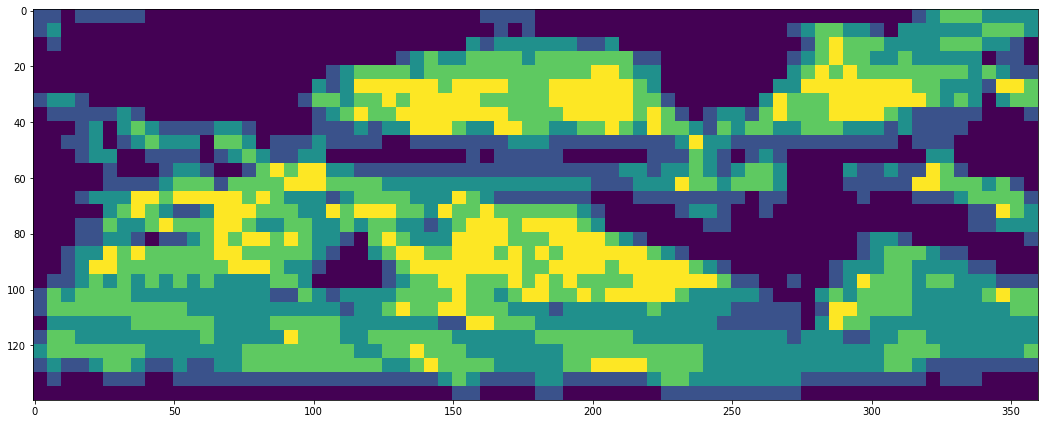

In [7]:
plt.figure(figsize=(18, 8))
plt.imshow(indeg_centrality_map.swapaxes(1, 0))
plt.show()

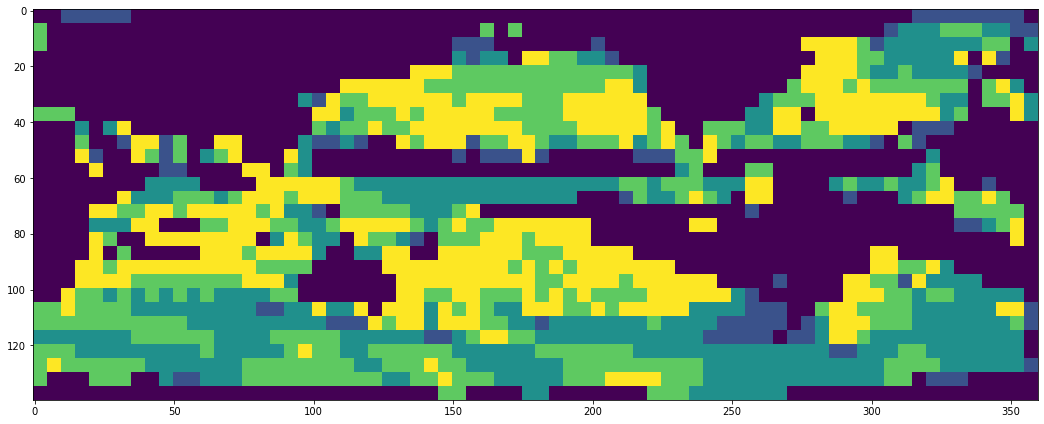

In [8]:
plt.figure(figsize=(18, 8))
plt.imshow(outdeg_centrality_map.swapaxes(1, 0))
plt.show()

The 'sources' will be the points where has maximum $(outdegree) - (indegree)$.

In [9]:
outdeg = nx.algorithms.out_degree_centrality(graph)
indeg = nx.algorithms.in_degree_centrality(graph)
delta = dict()
for k in outdeg.keys():
    delta[k] = outdeg[k] - indeg[k]
source_nodes = [k for k, v in delta.items() if v == max(delta.values())]
source_nodes

[(20, 55),
 (20, 70),
 (35, 50),
 (40, 80),
 (115, 80),
 (130, 45),
 (235, 75),
 (255, 65),
 (340, 15),
 (350, 35),
 (350, 80)]

The 'sinks' will be points where has minimum $(outdegree) - (indegree)$.

In [10]:
sink_nodes = [k for k, v in delta.items() if v == min(delta.values())]
sink_nodes

[(25, 85),
 (35, 85),
 (45, 75),
 (80, 80),
 (85, 55),
 (100, 55),
 (105, 70),
 (135, 85),
 (160, 70),
 (200, 80),
 (215, 85),
 (230, 90),
 (235, 45)]

Now, let's use min-cut max-flow theorm to determine points to deploy robots.

In [11]:
cut_points = set()
for source_node in source_nodes:
    for sink_node in sink_nodes:
        cut_points |= set(nx.minimum_node_cut(graph, source_node, sink_node))
cut_points

{(25, 70),
 (55, 80),
 (75, 65),
 (75, 70),
 (75, 80),
 (80, 60),
 (85, 60),
 (90, 60),
 (100, 70),
 (100, 75),
 (105, 75),
 (110, 75),
 (155, 70),
 (155, 75),
 (225, 60),
 (230, 45)}

Finally, plot the cut points.

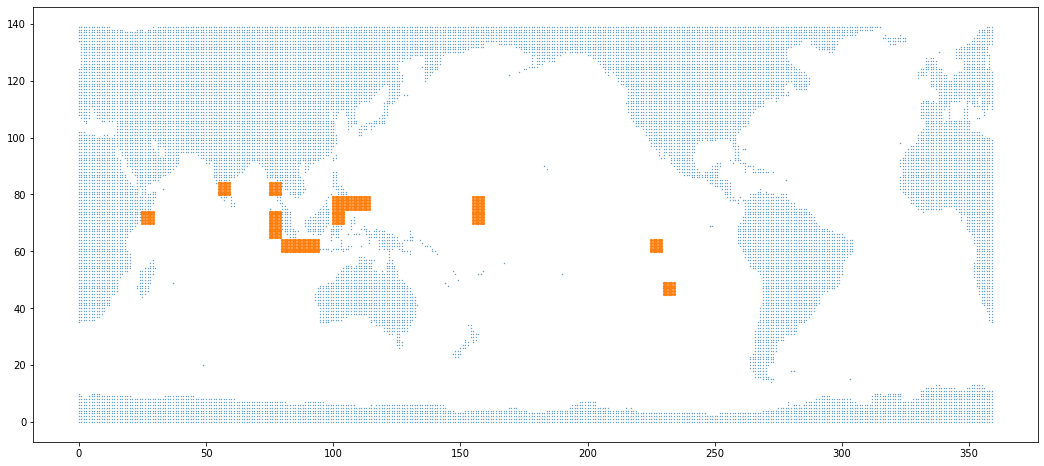

In [12]:
nan_mask = dataset.variables['uf'][0,0].mask
x_axis = np.argwhere(nan_mask)[:,1]
y_axis = 139 - np.argwhere(nan_mask)[:,0]
area_points = []
for x0, y0 in cut_points:
    for x in range(x0, x0 + 5):
        for y in range(y0, y0 + 5):
            area_points.append((x, y))
plt.figure(figsize=(18, 8))
plt.scatter(x_axis, y_axis, 0.1)
plt.scatter(np.array(area_points)[:,0], np.array(area_points)[:,1], 5)
plt.show()